# **Collaborative Filtering Recommender System using Random Walks and Music Genre Hierarchy based Method**

**Student:** Caio Eduardo Ramos Arães

**Mentor:** Gabriel Barbosa da Fonseca

**Subject:** TCC II

# References

1. Kaggle (2017). **Dataset for collaborative filters**. Acesso em: 11 abril 2024.
2. Yahoo (2002-2006). **R2 - yahoo! music user ratings of songs with artist, album, and genre meta information, v. 1.0**. Base de Dados.

# Python libraries

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install higra
!pip install cupy-cuda12x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 11.6 MB/s eta 0:00:00


In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import random
from collections import defaultdict
from collections import Counter
import pickle
import copy
import cupy as cp
import gc
import higra as hg

# Creating results subdirectories

In [ ]:
directories = ["datasets", "test_sets", "graph_visualization", "matrixes"]

for directory in directories:
  os.makedirs(os.path.join("sample_data", directory), exist_ok=True)

# Importing necessary files

In [ ]:
def download_file(file_url, file_path):
    response = requests.get(file_url)

    if response.status_code == 200:
      with open(file_path, 'wb') as file:
        file.write(response.content)
        print("File downloaded with success!")
    else:
        print("Failed to download the file.")

In [ ]:
kaggle_dataset_url = 'https://drive.google.com/uc?export=download&id=1GhD89UOUJMmI3uSa_NG7ZKuPsqUdLWFW'
kaggle_dataset_path = '/content/sample_data/datasets/kaggle_CF_dataset.csv'
download_file(kaggle_dataset_url, kaggle_dataset_path)

yahoomusic_dataset_url = 'https://drive.google.com/uc?export=download&id=1MMWzBoxrmjuqJh0Rbb1QPi-Mcqa_SRbq'
yahoomusic_dataset_path = '/content/sample_data/datasets/yahoomusic_dataset.txt'
download_file(yahoomusic_dataset_url, yahoomusic_dataset_path)

genre_hierarchy_url = 'https://drive.google.com/uc?export=download&id=12384M6UDIBvFJZQB8OjjmxSV3acTgAyN'
genre_hierarchy_path = '/content/sample_data/datasets/genre_hierarchy.txt'
download_file(genre_hierarchy_url, genre_hierarchy_path)

song_attributes_url = 'https://drive.google.com/uc?export=download&id=1ToT_d0nVptmMYiVeQoVr3_rO49iFNaQ8'
song_attributes_path = '/content/sample_data/datasets/song_attributes.txt'
download_file(song_attributes_url, song_attributes_path)

test_set_url = 'https://drive.google.com/uc?export=download&id=1lPT-92n8739vkxnO_EAyfpI8s4oZQPmq'
test_set_path = '/content/sample_data/test_sets/original_test_set.txt'
download_file(test_set_url, test_set_path)

File downloaded with success!
File downloaded with success!
File downloaded with success!
File downloaded with success!
File downloaded with success!


# Dataset preprocessing

In [ ]:
yahoomusic_dataset_preprocessed_path = '/content/sample_data/datasets/yahoomusic_dataset_filtered.txt'

In [ ]:
# Identifica músicas do gênero "Unknown"
unknown_genre_songs = set()
other_genre_song_count = 0
with open(song_attributes_path, 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        song_id, genre_id = parts[1], parts[3]
        if genre_id == '0': # gênero "Unknown"
            unknown_genre_songs.add(song_id)
        else:
            other_genre_song_count += 1

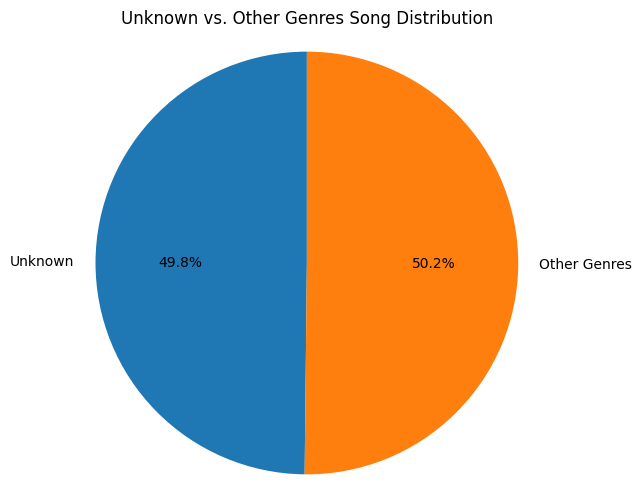

In [ ]:
labels = ['Unknown', 'Other Genres']
sizes = [len(unknown_genre_songs), other_genre_song_count]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Unknown vs. Other Genres Song Distribution')
plt.show()

In [ ]:
# Acessa o arquivo da base bloco por bloco (evitar estouro de memória)
def process_file_block(block):
    # Filtra músicas de gênero desconhecido
    filtered_block = block[~block['song_id'].isin(unknown_genre_songs)]

    # Seleciona 10 músicas por usuário com ao menos metade sendo de nota ou 4 ou superior
    filtered_users = []
    for user_id, group in filtered_block.groupby('user_id'):
        high_scores = group[group['rating'] >= 4]
        low_scores = group[group['rating'] < 4]

        # Verifica se há músicas suficientes de alta avaliação para garantir o requisito
        if len(high_scores) >= 5 and len(low_scores) >= 5:
            selected = pd.concat([high_scores.sample(n=5), low_scores.sample(n=min(5, len(low_scores)))])
        else:
            continue  # pula o usuário se não houver notas suficientes

        filtered_users.append(selected.sample(frac=1))

    return pd.concat(filtered_users)

In [ ]:
# Faz a leitura e processamento do arquivo em blocos
block_size = 10**5
with open(yahoomusic_dataset_path, 'r') as input_file, open(yahoomusic_dataset_preprocessed_path, 'w') as output_file:
    for block in pd.read_csv(input_file, sep='\t', names=['user_id', 'song_id', 'rating'], chunksize=block_size):
        processed_block = process_file_block(block)
        processed_block.to_csv(output_file, sep='\t', header=False, index=False, mode='a')

In [ ]:
unknown_genre_song_count = 0
other_genre_song_count = 0

with open('/content/sample_data/datasets/yahoomusic_dataset.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        song_id = parts[1]

        # Assuming song IDs from 'unknown_genre_songs' set are from 'Unknown' genre.
        if song_id in unknown_genre_songs:
            unknown_genre_song_count += 1
        else:
            other_genre_song_count += 1

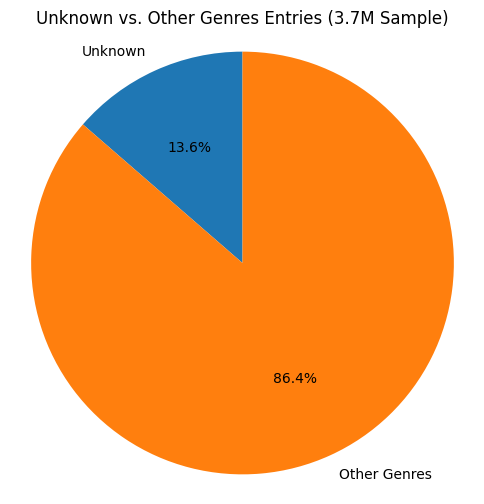

Number of songs from Unknown genre: 508333
Number of songs from Other genres: 3224130


In [ ]:
labels = ['Unknown', 'Other Genres']
sizes = [unknown_genre_song_count, other_genre_song_count]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Unknown vs. Other Genres Entries (3.7M Sample)')
plt.show()

print(f"Number of songs from Unknown genre: {unknown_genre_song_count}")
print(f"Number of songs from Other genres: {other_genre_song_count}")

In [ ]:
unknown_genre_song_count = 0
other_genre_song_count = 0

with open('/content/sample_data/datasets/yahoomusic_dataset_filtered.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        song_id = parts[1]

        if song_id in unknown_genre_songs:
            unknown_genre_song_count += 1
        else:
            other_genre_song_count += 1

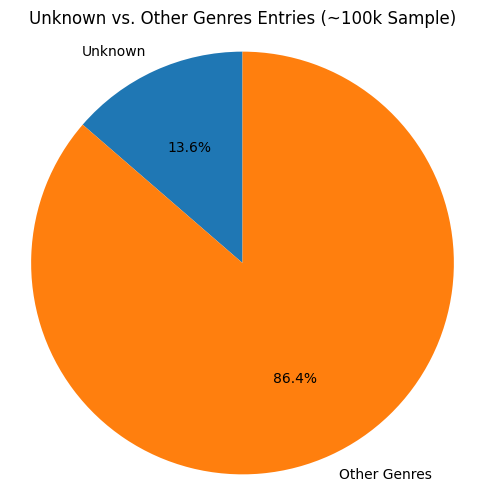

Number of songs from Unknown genre: 12373
Number of songs from Other genres: 78307


In [ ]:
labels = ['Unknown', 'Other Genres']
sizes = [unknown_genre_song_count, other_genre_song_count]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Unknown vs. Other Genres Entries (~100k Sample)')
plt.show()

print(f"Number of songs from Unknown genre: {unknown_genre_song_count}")
print(f"Number of songs from Other genres: {other_genre_song_count}")

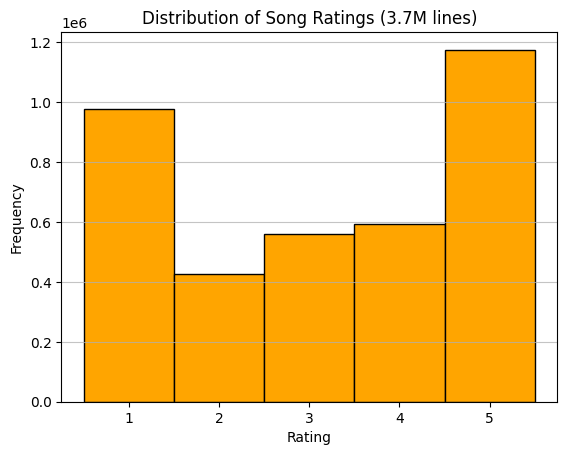

In [ ]:
data1 = pd.read_csv('/content/sample_data/datasets/yahoomusic_dataset.txt', sep='\t', names=['user_id', 'song_id', 'rating'])

plt.hist(data1['rating'], bins=[i - 0.5 for i in range(data1['rating'].min(), data1['rating'].max() + 2)], color='orange', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Song Ratings (3.7M lines)')
plt.grid(axis='y', alpha=0.75)
plt.show()

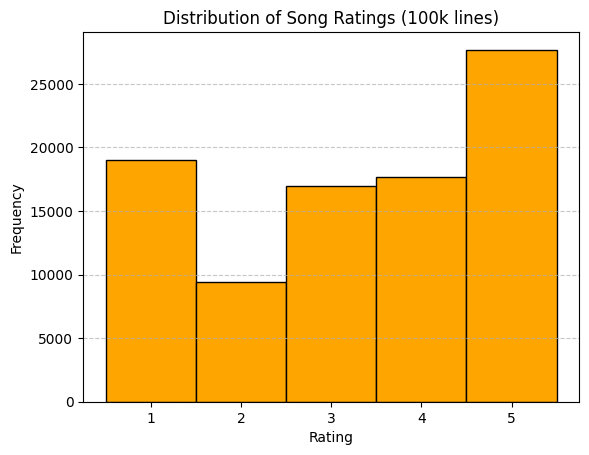

In [ ]:
data2 = pd.read_csv('/content/sample_data/datasets/yahoomusic_dataset_filtered.txt', sep='\t', names=['user_id', 'song_id', 'rating'])

plt.hist(data2['rating'], bins=[i - 0.5 for i in range(data2['rating'].min(), data2['rating'].max() + 2)], color='orange', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Song Ratings (100k lines)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

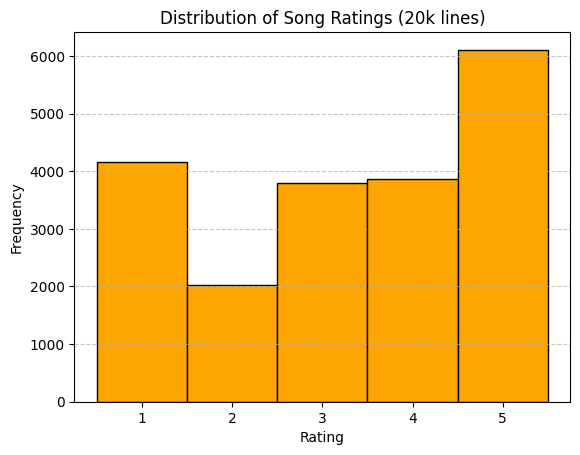

In [ ]:
data3 = pd.read_csv('/content/sample_data/datasets/yahoomusic_dataset_filtered.txt', sep='\t', names=['user_id', 'song_id', 'rating'])

plt.hist(data3['rating'], bins=[i - 0.5 for i in range(data3['rating'].min(), data3['rating'].max() + 2)], color='orange', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Song Ratings (20k lines)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Building user-music graph

### Importing graph (if already built and saved to file)

In [ ]:
#fh = open("/content/sample_data/user_song_genre_graph.adjlist", "wb")
#nx.write_adjlist(G, fh)

### Creates user-song graph

In [ ]:
G = nx.Graph()

In [ ]:
user_nodes = set()
song_nodes = set()

with open(yahoomusic_dataset_preprocessed_path, 'r') as file:
    for i, line in enumerate(file):
        # Define a quantidade de linhas lidas do dataset
        if i >= 20000 and len(user_nodes) >= 2000:
            break

        # Lê a linha do arquivo, separando as diferentes informações
        user_id, song_id, rating = line.strip().split('\t')
        user_id = f'user_{user_id}'
        song_id = f'song_{song_id}'
        rating = int(rating)

        user_nodes.add(user_id)
        song_nodes.add(song_id)

        G.add_node(user_id, type='user', weight=1)
        G.add_node(song_id, type='song', weight=1)

        # Adiciona arestas entre usuários e músicas com base na nota
        G.add_edge(user_id, song_id, weight=rating, type='user-song')

### Train-test split

In [ ]:
# Cria um conjunto de teste a partir das músicas já avaliadas pelos usuários
def create_train_test_split(G, user_nodes):
    test_set = []
    for user in user_nodes:
        # Cria uma lista com todas as músicas de nota 5 do usuário
        user_songs = [(song, G[user][song]['weight']) for song in G.neighbors(user) if G[user][song]['weight'] == 5]
        if user_songs:
            test_song, score = random.choice(user_songs)
            test_set.append((user, test_song))
            G.remove_edge(user, test_song)
        else:
            # Cria uma lista com todas as músicas de nota 4 ou superior do usuário
            user_songs = [(song, G[user][song]['weight']) for song in G.neighbors(user) if G[user][song]['weight'] >= 4]
            if user_songs:
                test_song, score = random.choice(user_songs)
                test_set.append((user, test_song))
                G.remove_edge(user, test_song)

    # Salva o conjunto de teste
    with open('/content/sample_data/test_sets/rand_gen_test_set.txt', 'w') as file:
        for user, song in test_set:
            file.write(f"{user}\t{song}\n")

    return test_set

In [ ]:
# Função auxiliar para ordenar os usuários
def get_identifier(node):
    return int(node.split('_')[1])

In [ ]:
users_list = sorted([node for node in G.nodes() if node.startswith('user_')], key=get_identifier)

In [ ]:
test_set = create_train_test_split(G, users_list)

### Adds genre hierarchy to graph

In [ ]:
genre_nodes = set()

with open(genre_hierarchy_path, 'r') as file:
    for line in file:
        # Lê a linha do arquivo, separando as diferentes informações
        genre_id, parent_id, level, genre_name = line.strip().split('\t')
        genre_id = f'genre_{genre_id}'
        parent_id = f'genre_{parent_id}' if parent_id != genre_id else None

        genre_nodes.add(genre_id)
        genre_nodes.add(parent_id)

        G.add_node(genre_id, label=genre_name, weight=1, level=int(level), type='genre')

        # Adiciona arestas entre gêneros e sub-gêneros
        if parent_id:
            G.add_edge(genre_id, parent_id, type='genre-genre')

# Remove arestas redundantes (de um gênero para ele mesmo)
for u, v in G.edges():
    if G[u][v]['type'] == 'genre-genre' and u == v:
        G.remove_edge(u, v)

#### Creates the "Music" genre and makes it the top of the hierarchy

In [ ]:
G.add_node('genre_216', label='Music', level=0, type='genre')
genre_nodes.add('genre_216')

# Identifica os nós de gêneros que estão no topo da hierarquia
top_genres = []
for node in G.nodes():
    if G.nodes[node].get('type') == 'genre':
        if G.nodes[node].get('level') == 1:
            top_genres.append(node)

# Conecta o nó "music" a todos os gêneros do topo atual
for genre in top_genres:
    G.add_edge('genre_216', genre, type='genre-genre')

### Links songs to their corresponding genre

In [ ]:
with open(song_attributes_path, 'r') as file:
    for line in file:
        # Lê a linha do arquivo, separando as diferentes informações
        song_id, album_id, artist_id, genre_id = line.strip().split('\t')
        song_id = f'song_{song_id}'
        genre_id = f'genre_{genre_id}'

        # Adiciona arestas entre músicas e gêneros
        if song_id in song_nodes:
            G.add_edge(song_id, genre_id, type='song-genre')

### Graph metrics

In [ ]:
print(f"Número de nós: {G.number_of_nodes()}")
print(f"Número de arestas: {G.number_of_edges()}")
print(f"Número de usuários: {len(user_nodes)}")
print(f"Número de músicas: {len(song_nodes)}")
print(f"Número de gêneros: {len(genre_nodes)}")

Número de nós: 15062
Número de arestas: 31102
Número de usuários: 2000
Número de músicas: 12845
Número de gêneros: 217


In [ ]:
largest_component = max(nx.connected_components(G), key=len)
largest_component_size = len(largest_component)
print("Tamanho do maior componente conectado:", largest_component_size)

Tamanho do maior componente conectado: 15061


### Subgraphs generation

In [ ]:
# Subgrafo com arestas apenas entre usuários e músicas
G_user_song = G.edge_subgraph([(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'user-song'])

# Subgrafo com arestas apenas do tipo música-gênero e gênero-gênero
G_song_genre = G.edge_subgraph([(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'song-genre' or d['type'] == 'genre-genre'])

# Subgrafo com arestas apenas entre gêneros e gêneros
G_genre_genre = G.edge_subgraph([(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'genre-genre'])

### Save graph to file

In [ ]:
nx.write_adjlist(G, "/content/sample_data/user_song_genre_graph.adjlist")
nx.write_adjlist(G_genre_genre, "/content/sample_data/genre_genre_graph.adjlist")

# Graph visualization

### Node and edge coloring

In [ ]:
node_colors = []            # grafo principal
node_colors_usermusic = []  # subgrafo de usuários e músicas
node_colors_musicgenre = [] # subgrafo de músicas e gêneros

for node in G.nodes():
    if node in user_nodes:
        # Cor para usuários
        node_colors.append('blue')
        node_colors_usermusic.append('blue')
    elif node in song_nodes:
        # Cor para músicas
        node_colors.append('green')
        node_colors_usermusic.append('green')
        node_colors_musicgenre.append('green')
    else:
        # Cor para gêneros
        node_colors.append('orange')
        node_colors_musicgenre.append('orange')

edge_colors = [
    'orange' if G[u][v]['type'] == 'genre-genre'    # cor para arestas entre gêneros
    else 'black' if G[u][v]['type'] == 'song-genre' # cor para arestas entre músicas e gêneros (talvez mudar para vermelho)
    else 'black' for u, v in G.edges()              # cor para arestas entre usuários e músicas
]

### Sample subgraph generator

In [ ]:
# Gera um subgrafo amostral do grafo principal através de um Random Walks de n passos
def random_subgraph_generator(G, n):
    starting_node = random.choice(list(G.nodes()))

    # Random Walk de n passos
    walk = [starting_node]
    for _ in range(n):
      neighbors = list(G.neighbors(walk[-1]))
      if neighbors:
        walk.append(random.choice(neighbors))
      else:
        break

    visited_nodes = set(walk)
    subgraph = G.subgraph(visited_nodes)

    return subgraph

In [ ]:
def draw_sample_subgraph(subgraph):
    # Coloração dos nós
    node_colors_subgraph = []
    edge_colors_subgraph = []
    for node in subgraph.nodes():
        if node in user_nodes:
            node_colors_subgraph.append('blue')
        elif node in song_nodes:
            node_colors_subgraph.append('green')
        else:
            node_colors_subgraph.append('orange')

    for u, v in subgraph.edges():
        if G[u][v]['type'] == 'genre-genre':
            edge_colors_subgraph.append('orange')
        else:
            edge_colors_subgraph.append('black')

    # Plotagem do subgrafo
    plt.figure(figsize=(8, 6))
    pos_subgraph = nx.spring_layout(subgraph, k=0.3)
    nx.draw_networkx_nodes(subgraph, pos_subgraph, node_size=100, node_color=node_colors_subgraph)
    nx.draw_networkx_edges(subgraph, pos_subgraph, edge_color=edge_colors_subgraph)
    #nx.draw_networkx_labels(subgraph, pos_subgraph, font_size=10, font_family='sans-serif')

    plt.title('Amostra do Grafo Principal')
    plt.show()

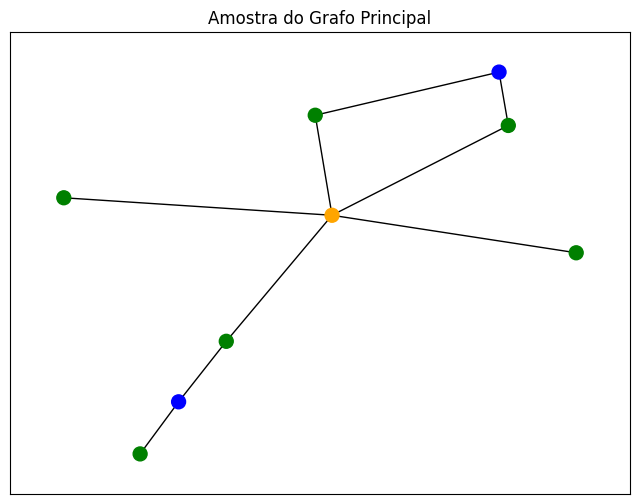

In [ ]:
sample_subgraph = random_subgraph_generator(G, 15)
draw_sample_subgraph(sample_subgraph)

# Random Walks (Transition Matrix)

## Sorts node list

In [ ]:
user_nodes_list = sorted([node for node in G.nodes() if node.startswith('user_')], key=get_identifier)
song_nodes_list  = sorted([node for node in G.nodes() if node.startswith('song_')], key=get_identifier)
genre_nodes_list = sorted([node for node in G.nodes() if node.startswith('genre_')], key=get_identifier)

# Unifica as listas mantendo a ordem
sorted_nodes = user_nodes_list + song_nodes_list + genre_nodes_list

## Random Walks Algorithm

In [ ]:
def create_adjacency_matrix(graph, sorted_nodes):
    node_index = {node: idx for idx, node in enumerate(sorted_nodes)}
    n = len(sorted_nodes)
    A = np.zeros((n, n))

    for u, v, data in graph.edges(data=True):
        idx_u = node_index[u]
        idx_v = node_index[v]
        if ( (u.startswith('genre_') and v.startswith('song_')) or
             (u.startswith('song_') and v.startswith('genre_')) ):
            A[idx_u, idx_v] = data.get('weight', 5)  # peso padrão é 5, se não especificado
            A[idx_v, idx_u] = data.get('weight', 5)  # grafo não-direcionado
        elif (u.startswith('genre_') and v.startswith('genre_')):
            A[idx_u, idx_v] = data.get('weight', 1)  # peso padrão é 1, se não especificado
            A[idx_v, idx_u] = data.get('weight', 1)  # grafo não-direcionado
        else:
            A[idx_u, idx_v] = data.get('weight', 0)  # peso padrão é 0, se não especificado
            A[idx_v, idx_u] = data.get('weight', 0)  # grafo não-direcionado

    return A

def create_transition_matrix(A):
    row_sums = A.sum(axis=1)
    S = np.where(row_sums[:, np.newaxis] == 0, 0, A / row_sums[:, np.newaxis])
    return S

In [ ]:
def compute_step_matrix(P, S, num_steps):
    for _ in range(num_steps):
        P = np.dot(P, S)
    return P

def compute_step_matrix_gpu(P, S, num_steps):
    # Transferir matrizes para a GPU
    P_gpu = cp.array(P)
    S_gpu = cp.array(S)

    # Loop de operações
    for _ in range(num_steps):
        P_gpu = cp.dot(P_gpu, S_gpu)

    # Retornar o resultado para a CPU, se necessário
    return cp.asnumpy(P_gpu)

In [ ]:
sorted_nodes = user_nodes_list + song_nodes_list + genre_nodes_list

A = create_adjacency_matrix(G, sorted_nodes)
S = create_transition_matrix(A)

P = copy.deepcopy(S)

## Usage

### 10 steps test

In [ ]:
#next_P = compute_step_matrix(P, S, 10)
next_P = compute_step_matrix_gpu(P, S, 10)

with open('/content/sample_data/matrixes/step_matrix_10.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + sorted_nodes)
    for i, row in enumerate(next_P):
        writer.writerow([sorted_nodes[i]] + list(row))

### 100 steps test

In [ ]:
del next_P
gc.collect()
#next_P = compute_step_matrix(P, S, 100)
next_P = compute_step_matrix_gpu(P, S, 100)

with open('/content/sample_data/matrixes/step_matrix_100.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + sorted_nodes)
    for i, row in enumerate(next_P):
        writer.writerow([sorted_nodes[i]] + list(row))

### 200 steps test

In [ ]:
del next_P
gc.collect()
#next_P = compute_step_matrix(P, S, 200)
next_P = compute_step_matrix_gpu(P, S, 200)

with open('/content/sample_data/matrixes/step_matrix_1000.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + sorted_nodes)
    for i, row in enumerate(next_P):
        writer.writerow([sorted_nodes[i]] + list(row))

### Save results to file

In [ ]:
# Salva a matriz de adjacência
with open('/content/sample_data/matrixes/adjacency_matrix.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + sorted_nodes)
    for i, row in enumerate(A):
        writer.writerow([sorted_nodes[i]] + list(row))

# Salva a matriz de transição
with open('/content/sample_data/matrixes/transition_matrix.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + sorted_nodes)
    for i, row in enumerate(S):
        writer.writerow([sorted_nodes[i]] + list(row))

# Salva a matriz de passos (última gerada)
with open('/content/sample_data/matrixes/step_matrix.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([''] + sorted_nodes)
    for i, row in enumerate(next_P):
        writer.writerow([sorted_nodes[i]] + list(row))

# Results analysis

## Hit rate line graph

In [ ]:
def get_top_recommendations(user_id, next_P, song_nodes_list, G, percent):
    # Filtra músicas que o usuário já avaliou
    user_index = sorted_nodes.index(user_id)
    scores = next_P[user_index]

    # Exclui músicas já avaliadas
    rated_songs = {neighbor for neighbor in G.neighbors(user_id) if neighbor.startswith('song_')}
    scores_filtered = [(song, score) for song, score in zip(song_nodes_list, scores) if song not in rated_songs]

    # Ordena por pontuação e seleciona o percentil especificado
    scores_filtered.sort(key=lambda x: x[1], reverse=True)
    top_count = int(percent * len(scores_filtered) / 100)
    return [song for song, _ in scores_filtered[:top_count]]

In [ ]:
def get_hit_rate(percentiles, steps_matrix_path):
    hit_rates = []

    with open(steps_matrix_path, 'r') as file:
        next_P = np.genfromtxt(file, delimiter=',', skip_header=1, dtype=float)

    # Avalia a taxa de acerto para cada percentil
    for p in percentiles:
        hits = 0
        total = 0

        for user, song in test_set:
            top_recommendations = get_top_recommendations(user, next_P, song_nodes_list, G, p)
            if song in top_recommendations:
                hits += 1
            total += 1

        hit_rate = hits / total if total > 0 else 0
        hit_rates.append(hit_rate)

    return hit_rates

In [ ]:
percentiles = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ideal_gain = [0.1, 0.3, 0.5, 0.75, 0.9, 0.95, 0.963, 0.97, 0.975, 0.98, 0.984, 0.99]

hit_rate_10_steps = get_hit_rate(percentiles,'/content/sample_data/matrixes/step_matrix_10.csv')

hit_rate_100_steps = get_hit_rate(percentiles,'/content/sample_data/matrixes/step_matrix_100.csv')

hit_rate_200_steps = get_hit_rate(percentiles,'/content/sample_data/matrixes/step_matrix_1000.csv')

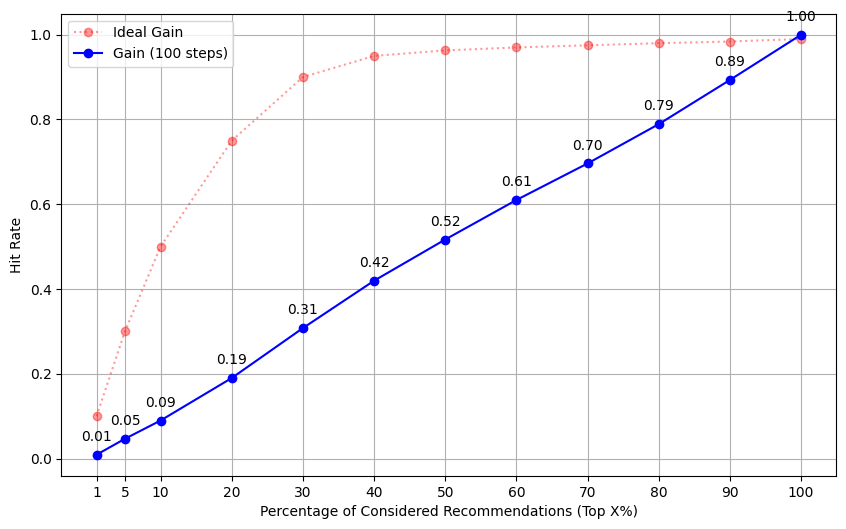

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(percentiles, ideal_gain, marker='o', linestyle='dotted', color='red', alpha=0.4, label='Ideal Gain')
plt.plot(percentiles, hit_rate_100_steps, marker='o', color='blue', label='Gain (100 steps)')
plt.xticks(percentiles)
plt.xlabel('Percentage of Considered Recommendations (Top X%)')
plt.ylabel('Hit Rate')
plt.grid()
plt.legend()

# Adiciona os valores de Y ao lado de cada marcador
for i, txt in enumerate(hit_rate_100_steps):
    plt.annotate(f"{txt:.2f}", (percentiles[i], hit_rate_100_steps[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

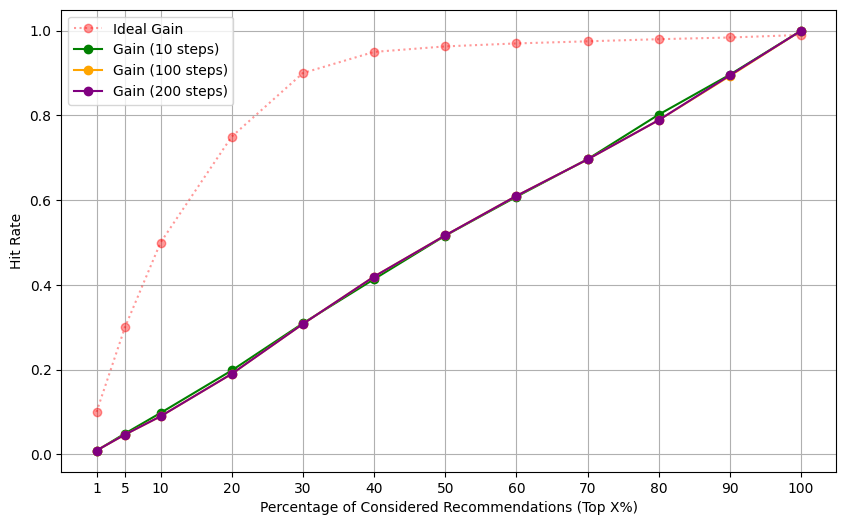

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(percentiles, ideal_gain, marker='o', linestyle='dashed', color='red', alpha=0.4, label='Ideal Gain')
plt.plot(percentiles, hit_rate_10_steps, marker='o', color='green', label='Gain (10 steps)')
plt.plot(percentiles, hit_rate_100_steps, marker='o', color='orange', label='Gain (100 steps)')
plt.plot(percentiles, hit_rate_200_steps, marker='o', color='purple', label='Gain (200 steps)')
plt.xticks(percentiles)
plt.xlabel('Percentage of Considered Recommendations (Top X%)')
plt.ylabel('Hit Rate')
plt.grid()
plt.legend()

plt.show()

## Genre distance histogram

In [ ]:
def calculate_genre_distance(test_song, recommended_song, G, G_genre_genre):
    # Identifica o gênero da música no test_set
    test_genre = next((neighbor for neighbor in G.neighbors(test_song) if neighbor.startswith('genre_')), None)
    if not test_genre:
        return None  # se não houver gênero associado, ignore a música

    # Encontra o gênero da música recomendada
    recommended_genre = next((neighbor for neighbor in G.neighbors(recommended_song) if neighbor.startswith('genre_')), None)
    if recommended_genre:
        distance = nx.shortest_path_length(G_genre_genre, source=test_genre, target=recommended_genre)

    return distance

def calculate_average_genre_distance(test_song, recommended_songs, G, G_genre_genre):
    # Identifica o gênero da música no test_set
    test_genre = next((neighbor for neighbor in G.neighbors(test_song) if neighbor.startswith('genre_')), None)
    if not test_genre:
        return None  # se não houver gênero associado, ignore a música

    distances = []
    for song in recommended_songs:
        # Encontra o gênero da música recomendada
        recommended_genre = next((neighbor for neighbor in G.neighbors(song) if neighbor.startswith('genre_')), None)
        if recommended_genre:
            distance = nx.shortest_path_length(G_genre_genre, source=test_genre, target=recommended_genre)
            distances.append(distance)

    # Retorna a média das distâncias ou None, se não houver distâncias
    return int(np.ceil(np.mean(distances))) if distances else None
    #return int(round(np.mean(distances))) if distances else None

### Average genre distance histogram for Top 5% recommendations

In [ ]:
distances = []
percent = 5  # considera as top 5% músicas recomendadas

for user, test_song in test_set:
    top_5_percent_recommendations = get_top_recommendations(user, next_P, song_nodes_list, G, percent)
    avg_distance = calculate_average_genre_distance(test_song, top_5_percent_recommendations, G, G_genre_genre)
    if avg_distance is not None:
        distances.append(avg_distance)

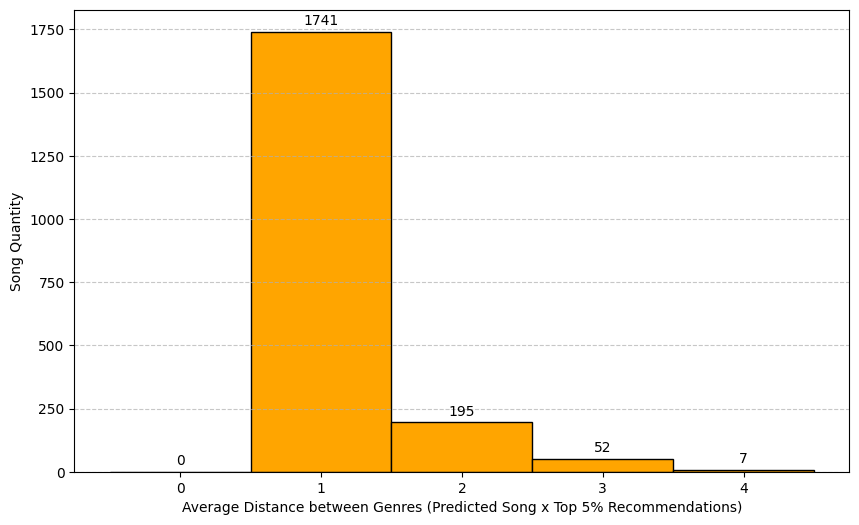

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=[i - 0.5 for i in range(max(distances) + 2)], color='orange', edgecolor='black')
#plt.title('Histograma da Distância Média entre Gêneros das Músicas Previstas e Recomendadas')
plt.xlabel('Average Distance between Genres (Predicted Song x Top 5% Recommendations)')
plt.ylabel('Song Quantity')

# Ajustando a escala do eixo X e Y para inteira
plt.xticks(range(max(distances) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona o valor de Y no topo de cada barra
for i in range(max(distances) + 1):
    count = distances.count(i)
    plt.annotate(f"{count}", (i, count), textcoords="offset points", xytext=(0,3), ha='center', va='bottom')

plt.show()

### Genre distance histogram for Top 1 recommendation

In [ ]:
distances = []

for user, test_song in test_set:
    top_1_percent_recommendations = get_top_recommendations(user, next_P, song_nodes_list, G, 1)
    distance = calculate_genre_distance(test_song, top_1_percent_recommendations[0], G, G_genre_genre)
    if distance is not None:
        distances.append(distance)

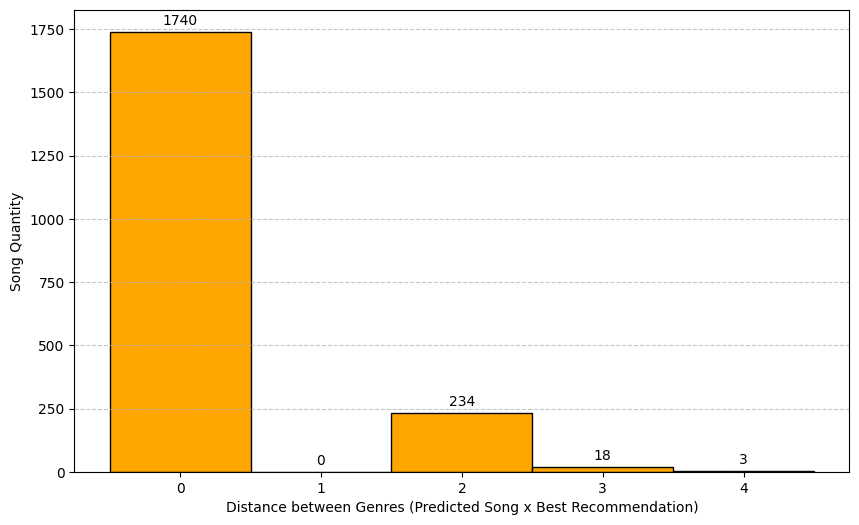

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=[i - 0.5 for i in range(max(distances) + 2)], color='orange', edgecolor='black')
#plt.title('Histograma da Distância entre Gêneros das Músicas Previstas e da Recomendação Top 1')
plt.xlabel('Distance between Genres (Predicted Song x Best Recommendation)')
plt.ylabel('Song Quantity')

# Ajustando a escala do eixo X e Y para inteira
plt.xticks(range(max(distances) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona o valor de Y no topo de cada barra
for i in range(max(distances) + 1):
    count = distances.count(i)
    plt.annotate(f"{count}", (i, count), textcoords="offset points", xytext=(0,3), ha='center', va='bottom')

plt.show()